#### Trial #4 (6 labels) not balanced data with different param

lr = 5e-6, batch size = 16, epoch = 15, warm up = 0.05

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
import torch
from torch.nn.functional import softmax
import datasets
from datasets import load_dataset, Dataset
import random
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import F1Score
import pandas as pd
import numpy as np
pd.options.mode.copy_on_write = True

In [8]:
fpath = "../datasets_ready/combined_dataset.csv"
df5 = pd.read_csv(fpath)
df5['band'] = df5['band'].round(1)


reverse_mapping_3 = {
    3.5: 0, 4.0: 0,
    4.5: 1, 5.0: 1,
    5.5: 2, 6.0: 2,
    6.5: 3, 7.0: 3,
    7.5: 4, 8.0: 4,
    8.5: 5, 9.0: 5
}

# Apply mapping
df5['band'] = df5['band'].map(reverse_mapping_3)

# Sample the maximum available size for each class
df_sampled5 = df5.groupby('band', group_keys=False).apply(
    lambda x: x.sample(len(x), random_state=42)
).reset_index(drop=True)

dataset5 = Dataset.from_pandas(df_sampled5)

C:\Users\26597\AppData\Local\Temp\ipykernel_6220\369432114.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled5 = df5.groupby('band', group_keys=False).apply(


In [9]:
dataset5

Dataset({
    features: ['prompt', 'essay', 'evaluation', 'band'],
    num_rows: 0
})

In [ ]:
num_labels_5 = 6

# Load the tokenizer and model
tokenizer5 = AutoTokenizer.from_pretrained("mrm8488/deberta-v3-ft-financial-news-sentiment-analysis")
model5 = AutoModelForSequenceClassification.from_pretrained("mrm8488/deberta-v3-ft-financial-news-sentiment-analysis", num_labels=num_labels_5, ignore_mismatched_sizes=True)

# Tokenization function
def tokenize_function(examples):
    # Concatenate the input columns for each example in the batch
    combined_text = [
        p + " " + e + " " + t for p, e, t in zip(examples["prompt"], examples["essay"], examples["text"])
    ]
    # Tokenize the concatenated text
    return tokenizer5(combined_text, padding="max_length", truncation=True, max_length=1024)

# Tokenize the dataset
tokenized_datasets5 = dataset5.map(tokenize_function, batched=True)
tokenized_datasets5 = tokenized_datasets5.remove_columns(["prompt", "essay", "text"])
tokenized_datasets5 = tokenized_datasets5.rename_column("score", "labels")
tokenized_datasets5.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Get the labels from the tokenized dataset
labels5 = tokenized_datasets5["labels"]

# Get the unique labels
unique_labels5 = np.unique(labels5)

# Store the indices for each label
label_to_indices5 = {label: np.where(labels5 == label)[0] for label in unique_labels5}

# Lists to hold the train and validation indices
train_indices5 = []
val_indices5 = []

# For each label, split the indices into train and validation
for label, indices in label_to_indices5.items():
    # Shuffle the indices within each label to ensure random splitting
    np.random.shuffle(indices)
    
    # Split 80% for training, 20% for validation
    split_idx = int(0.8 * len(indices))
    train_indices5.extend(indices[:split_idx])
    val_indices5.extend(indices[split_idx:])

# Convert indices to tensors
train_indices5 = torch.tensor(train_indices5)
val_indices5 = torch.tensor(val_indices5)

# Create Subsets for train and validation datasets
train_dataset5 = Subset(tokenized_datasets5, train_indices5)
eval_dataset5 = Subset(tokenized_datasets5, val_indices5)

# Dataloaders
train_dataloader5 = DataLoader(train_dataset5, shuffle=True, batch_size=12)
eval_dataloader5 = DataLoader(eval_dataset5, batch_size=12)

# Set up optimizer and scheduler
optimizer5 = AdamW(model5.parameters(), lr=5e-6)
num_epochs5 = 5
num_training_steps5 = num_epochs5 * len(train_dataloader5)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer5, num_warmup_steps=int(0.05*num_training_steps5), num_training_steps=num_training_steps5
)

# Move model to device (GPU if available)
device5 = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model5.to(device5)

# Initialize lists to track training/validation losses and accuracies
train_losses5 = []
val_losses5 = []
val_f1_scores5 = []


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at mrm8488/deberta-v3-ft-financial-news-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8352 [00:00<?, ? examples/s]

In [12]:
# pre-training checklist
# load training progress

# Specify the file name from which to load the model
modelsavename = "saved_models/second.pt"

# Load the saved state_dict into the model
with open(modelsavename, "rb") as f:
    model5.load_state_dict(torch.load(f))

# Move model to the device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model5.to(device)

print(f"Model loaded from {modelsavename}")

/var/folders/fq/8t499y3d3t7fbz0k_rdphz7m0000gn/T/ipykernel_59964/2025300923.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model5.load_state_dict(torch.load(f))


Model loaded from saved_models/second.pt


 20%|██        | 557/2785 [3:31:03<11:53:30, 19.21s/it]

Model saved to saved_models/grammatical_epoch1_F10.4598.pt
Epoch 1/4: train loss 1.1176, val loss 1.2791, val f1 score 0.4598


 40%|████      | 1114/2785 [7:12:19<8:44:03, 18.82s/it]  

Model saved to saved_models/grammatical_epoch2_F10.5031.pt
Epoch 2/4: train loss 1.1424, val loss 1.1692, val f1 score 0.5031


 60%|██████    | 1671/2785 [10:52:57<5:53:36, 19.05s/it] 

Model saved to saved_models/grammatical_epoch3_F10.5055.pt
Epoch 3/4: train loss 1.1072, val loss 1.1768, val f1 score 0.5055


 80%|████████  | 2228/2785 [14:32:56<2:52:24, 18.57s/it]  

Model saved to saved_models/grammatical_epoch4_F10.5099.pt
Epoch 4/4: train loss 1.0759, val loss 1.1786, val f1 score 0.5099


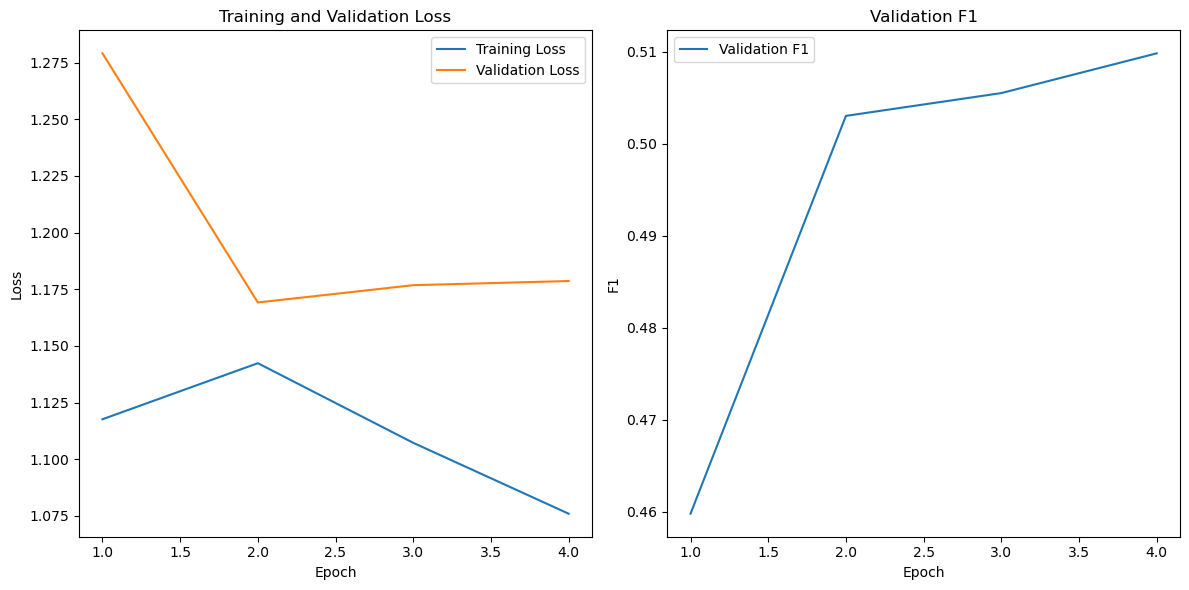

Final validation F1: 0.5099


In [13]:
progress_bar5 = tqdm(range(num_training_steps5))
num_epochs5 = 4

for epoch in range(num_epochs5):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric.reset()
    model5.train()

    for batch in train_dataloader5:
        batch = {k: v.to(device5) for k, v in batch.items()}
        outputs = model5(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer5.step()
        lr_scheduler.step()
        optimizer5.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar5.update(1)

    # Evaluate the model
    model5.eval()
    for batch in eval_dataloader5:
        batch = {k: v.to(device5) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model5(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"].long())

        epoch_val_loss += loss.item()
        f1_metric(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses5.append(epoch_val_loss / len(eval_dataloader5))
    val_f1 = f1_metric.compute().item()
    val_f1_scores5.append(val_f1)
    
    fname = f"grammatical_epoch{epoch + 1}_F1{val_f1_scores5[-1]:.4f}.pt"

    # Save the model's state_dict
    with open(f"saved_models/{fname}", "wb") as f:
        torch.save(model5.state_dict(), f)

    print(f"Model saved to saved_models/{fname}")

    # Record training loss for the epoch
    train_losses5.append(epoch_train_loss / len(train_dataloader5))

    print(f"Epoch {epoch + 1}/{num_epochs5}: train loss {train_losses5[-1]:.4f}, val loss {val_losses5[-1]:.4f}, val f1 score {val_f1_scores5[-1]:.4f}")
    

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses5, val_losses5, val_f1_scores5)

# Print final validation accuracy
print(f"Final validation F1: {val_f1_scores5[-1]:.4f}")

In [7]:
modelsavename5 = "second.pt"

# Save the model's state_dict
with open(modelsavename5, "wb") as f:
    torch.save(model5.state_dict(), f)

print(f"Model saved as {modelsavename5}")

Model saved as second.pt


In [3]:
# Specify the file name from which to load the model
modelsavename = "deberta_9k_ep15_4597.pt"

# Initialize the same model architecture
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/deberta-v3-ft-financial-news-sentiment-analysis",num_labels=6, ignore_mismatched_sizes=True)

# Load the saved state_dict into the model
with open(modelsavename, "rb") as f:
    model.load_state_dict(torch.load(f))

# Move model to the device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

tokenizer = AutoTokenizer.from_pretrained("mrm8488/deberta-v3-ft-financial-news-sentiment-analysis")

print(f"Model loaded from {modelsavename}")

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at mrm8488/deberta-v3-ft-financial-news-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/vx/57ntql9x3lg7fsldp3xp6w1c0000gn/T/ipykernel_8120/2724072977.py:9: FutureWarning: You are using `torch.load` wi

Model loaded from deberta_9k_ep15_4597.pt


/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
def get_class(input_text):
  # Tokenize input and get model output
  inputs = tokenizer5(input_text, return_tensors="pt")

  # Get logits (output for classification)
  outputs = model5(**inputs)
  logits = outputs.logits

  # Convert logits to probabilities using softmax
#   probs = softmax(logits, dim=1)

  # Map classes to polarity values
#   polarity_values = torch.tensor([-1.0, 0.0, 1.0])

  # Calculate polarity score as the weighted sum of probabilities
#   polarity_score = torch.sum(probs * polarity_values, dim=1).item()

  # Get the predicted class (optional, for reference)
  predicted_class = logits.argmax(dim=1).item()

  return predicted_class

In [15]:
# task achieve: 6.5
input_text = """Prompt: Today people are surrounded by advertising. This affects what people think is important and has a negative impact on people's lives. To what extent do you agree or disagree?

Essay: In this digital world, people are encircled with various types of advertisements. It is omnipresent for all, TV adverts, Social Media Marketing, billboards, Personal advertisements and many more diverse ways. while this phenomenon is escalating to extremely new level, people are in influence of it. In my view, it has more positive effects than harmful.

Because of advertisements, people are aware of current products in market. At some extent, it educates the people and provides the knowledge. For an instance, In India serious disease like  polio is no more and the major success goes to awareness campaign help by famous personality with the use of digital marketing and TV advertisements. Moreover, to bind user with interest usually companies display various new idea and it add major value in entertainment world.

However, the critical impacts are also not avoidable.Firstly, it exposes kids and young generation towards the violence and  inappropriate content sometime. Secondly, Advertisements with various discounts and offers, make people lure to do impulsive shopping. Increasing obesity is also one of consequence of advertisement of junk food. In addition, few times people get influenced by various advertisings and tend to work more to achieve never ending desire of buying stuff, this approach add up to the stress and frustration. What more, kids might suffer from harmful psychological effects when their parents are unable to afford various products shown in advertisements.

To put this in a nutshell, I can say that advertisement is beneficial phenomenon with a number of insignificant drawbacks. In my view, negative advertising effects can be lowered with help of government using stringent approach and awareness campaigns.

Comment: The candidate has adequately addressed the given task by discussing the positive and negative impacts of advertising on people's lives. They have provided relevant arguments and examples to support their claims. However, some aspects of the task, such as the impact on people's values and priorities, could have been explored in more depth. Overall, the candidate has demonstrated a good understanding of the topic and has fulfilled the requirements of the task.
"""

pred_class = get_class(input_text)
print(pred_class)

3


In [16]:
# task achieve: 8.5
input_text = """Prompt: Some people think that children should be taught at school to recycle materials and avoid waste. Other people believe that children should be taught this at home. Discuss both opinions and give your own opinion.

Essay: Green energy is been regarded as the future energy for mankind, moreover,the fundamentals of achieving the same rely on reprocessing the waste. While some argue this should be educated at school level and others would like this initiative done from their homes. In this essay, we shall discuss both views and state my opinion.

On one hand, schools have been institutional in developing children cognitive skills therefore all good behaviours are cultivated here. While waste management is a profound topic and requires an in-depth analysis of how the process works or implemented. Furthermore, tutors have authority over their pupils hence they pick up subject matters efficiently. Educational institute emphasis on reusing most of the resources at school, adding to this, student comprehend the reason and significance of reducing waste such as plastic and glass. For instance, Science as a subject, demonstrates the impact of plastic and non-biodegradable materials on earth’s soil, as these take up nearly million years to decompose, consequently converting these materials to toxic and destroying mother nature.

On the other hand, young people often look up to their parents as inspiration to learn life skills. As they spend quality time at home, all behavioural attributes of kids are related to  them, so they should bring upon the habits of recycling waste at home. For example, when parents bring thumb rule of segregating waste at their homes, children at young age practice to keep waste as per the category and this behaviour can be carried across at various places like parks, social events, and public transport. As a result, children are instilled with the habit of re-cycling and segregating waste at an early age

To conclude, education on recycling waste can be beneficial as it explains the impacts on the environment and what could be done to avoid this catastrophe. Also,parenting should ensure their children learn the habit of separating waste at home. In my opinion, both methodologies must be implemented to have a better future.

Comment: The candidate effectively addressed the given task by discussing both opinions on whether children should be taught to recycle at school or at home. The ideas presented are clear, relevant, and coherent, with each paragraph focusing on one aspect of the task. All aspects of the task are adequately covered, with arguments and evidence provided to support each opinion. The candidate demonstrates a good understanding of the task requirements and fulfills them appropriately.
"""

pred_class = get_class(input_text)
print(pred_class)

4
